# Algorithm Convergence
In this notebook, we explore the theoretical guarantees of oru algorithm. In particular, we check to make sure that oru algorithm error bounds hold as we increase the number of smaples that fall within the truncation set.

In [11]:
import sys 
sys.path.append('..')
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython

from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle

TABLE_NAME = 'logs'

# Experiment Hyperparameters
Here, are the hyperparameters that you can use for modify for each run of the experiment. Please make sure to fill in teh out_dir and exp keys in the dictionary

In [12]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "lr": 1e-1,
    "var_": 1,
    "trials": 3,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
#     'out_dir': '<FILL IN OUT_DIR HERE>', 
    'out_dir': '/Users/patroklos/Desktop/convergence/', 
#     'exp': '<FILL IN EXP HERE>', 
    'exp': 'trial', 
    'bs': 10, 
    'steps': 2500, 
    'step_lr': 100, 
    'step_lr_gamma': .9, 
    'tol': 1e-2, 
    'trials': 20, 
    'n': 100,
})
mse_loss = ch.nn.MSELoss()

In [13]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

In [14]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 10, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
samples = [10, 25, 50, 100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 5000]
phi = oracle.Left(1.0)
noise_var = Tensor([1.0])

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(ch.ones(k, d))
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None

# generate data until max number of samples fall within the truncation set
X, noised = Tensor([]), Tensor([])
all_x_trunc, all_y_trunc = Tensor([]), Tensor([])
with ch.no_grad():
    while all_x_trunc.size(0) < samples[-1]: 
        x_ = dist.sample(ch.Size([samples[-1], d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([samples[-1]]))
        new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(samples[-1], 1)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
        all_y_trunc, all_x_trunc = ch.cat([all_y_trunc, new_noised[indices]]), ch.cat([all_x_trunc, x_[indices]])
        X, noised = ch.cat([X, x_]), ch.cat([noised, new_noised])
        
alpha = Tensor([all_y_trunc.size(0) / noised.size(0)])

for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir + args.exp)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
            
    # shuffle x_trunc, y_trunc
    rand_perm = ch.randperm(all_y_trunc.size(0))
    x_trunc_pool, y_trunc_pool = all_x_trunc[rand_perm], all_y_trunc[rand_perm]
    
    # iterate over samples
    for s in samples: 
        # take s truncated samples
        x_trunc, y_trunc = x_trunc_pool[:s], y_trunc_pool[:s]

        # 10% of truncated data is validation data
        val = int(.1*s)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with unknown variance. 
        This means that we want to standardize our dependent variable 
        by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        intervals = [[-1, 1], [2, 5]]
        emp_stand_intervals = [(int_[0]/math.sqrt(float(emp_noise_var)), int_[1]/math.sqrt(float(emp_noise_var))) for int_ in intervals]
        emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)        

        # truncated regression with unknown variance
        unknown_kwargs = { 
            'phi': oracle.Left(phi.left / ch.sqrt(emp_noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
        unknown_var = unknown_trunc_reg.variance * emp_noise_var
        w, w0 = (((unknown_trunc_reg.weight) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var)))
        unknown_params = ch.cat([w, w0]).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })
        IPython.display.clear_output()


        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Logging in: /Users/patroklos/Desktop/convergence/trial/130dc978-a8a4-4d04-85d8-dcc81707d3dd
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-26379a4e18d2>", line 33, in <module>
    store = Store(args.out_dir + args.exp)
  File "/opt/anaconda3/lib/python3.7/site-packages/cox-0.1.post3-py3.7.egg/cox/store.py", line 102, in __init__
    self.tensorboard = SummaryWriter(self.tb_dir)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorboardX/writer.py", line 275, in __init__
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorboardX/writer.py", line 327, in _get_file_writer
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorboardX/writer.py", line 95, in __init__
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorboardX/event_file_writer.py", line 105, in __init__
  File "/opt/anaconda3/lib/pytho

OSError: [Errno 24] Too many open files

In [6]:
reader = CollectionReader(args.out_dir + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: The file '/Users/patroklos/Desktop/convergencetrial/767f1f6f-0ff1-4464-927f-cd922ff5ee5e/store.h5' is already opened, but not in read-only mode (as requested).

Combine Error Columns

In [14]:
logs['unknown_epsilon'] = logs['unknown_param_mse']**(.5) + logs['unknown_var_l1']
logs['ols_epsilon'] = logs['ols_param_mse']**(.5) + logs['ols_var_l1']

In [15]:
cols = ['unknown_epsilon', 'num_samples', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

In [16]:
cols = ['ols_epsilon', 'num_samples', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

Remove the Best and the Worse Trials for Each Number of Samples

[Text(0, 0.5, '$||\\hat W - W^{*}||_{2} + |\\hat \\sigma^{2} - \\sigma^{*2}|$'),
 Text(0.5, 0, 'Number of Samples in S')]

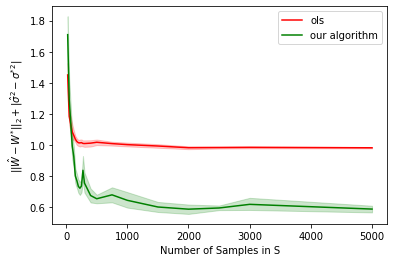

In [17]:
ax = sns.lineplot(data=ols_logs[ols_logs['num_samples'] >= 25], x='num_samples', y='ols_epsilon', label='ols', color='red')
ax = sns.lineplot(data=unknown_logs[unknown_logs['num_samples'] >= 25], x='num_samples', y='unknown_epsilon', label='our algorithm', color='green')
ax.set(xlabel='Number of Samples in S', ylabel='$||\hat W - W^{*}||_{2} + |\hat \sigma^{2} - \sigma^{*2}|$')